In [24]:
from gw_signal_tools.waveform_utils import (
    td_to_fd_waveform, fd_to_td_waveform,
    pad_to_get_target_df, restrict_f_range
)

import astropy.units as u
import lalsimulation.gwsignal.core.waveform as wfm
import numpy as np
import matplotlib.pyplot as plt

# Waveform Conversion Verifications

First we need an example signal

In [25]:
# Define the dictionary
deltaT = 1./2048.*u.s
f_min = 20.*u.Hz  # Cutoff frequency
f_ref = 20.*u.Hz  # Frequency where we specify spins
distance = 440.*u.Mpc
inclination = 2.7*u.rad  # Value taken from posteriors.ipynb, where posterior of inclination is plotted
phiRef = 0.*u.rad
eccentricity = 0.*u.dimensionless_unscaled
longAscNodes = 0.*u.rad
meanPerAno = 0.*u.rad


parameters_gw150914 = {
    'mass1' : 36*u.solMass,
    'mass2' : 29*u.solMass,
    'deltaT' : deltaT,
    'f22_start' : f_min,
    'f22_ref': f_ref,
    'phi_ref' : phiRef,
    'distance' : distance,
    'inclination' : inclination,
    'eccentricity' : eccentricity,
    'longAscNodes' : longAscNodes,
    'meanPerAno' : meanPerAno,
    'condition' : 0
}

# Define the approximant
approximant = 'IMRPhenomXPHM'

# Call the generator
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)


# Generate time domain waveform
hp_t, _ = wfm.GenerateTDWaveform(parameters_gw150914, gen)


# Two waveforms will be generated in frequency domain, first with finer
# sampling and then with coarser one
hp_f_fine, _ = wfm.GenerateFDWaveform(parameters_gw150914, gen)

hp_f_coarse, _ = wfm.GenerateFDWaveform(parameters_gw150914 | {'deltaF': 1.0 / (hp_t.size * hp_t.dx)}, gen)

## Sanity Checks

Transforming to one domain and back must yield the same waveform, up to essentially numerical precision

### Frequency Domain

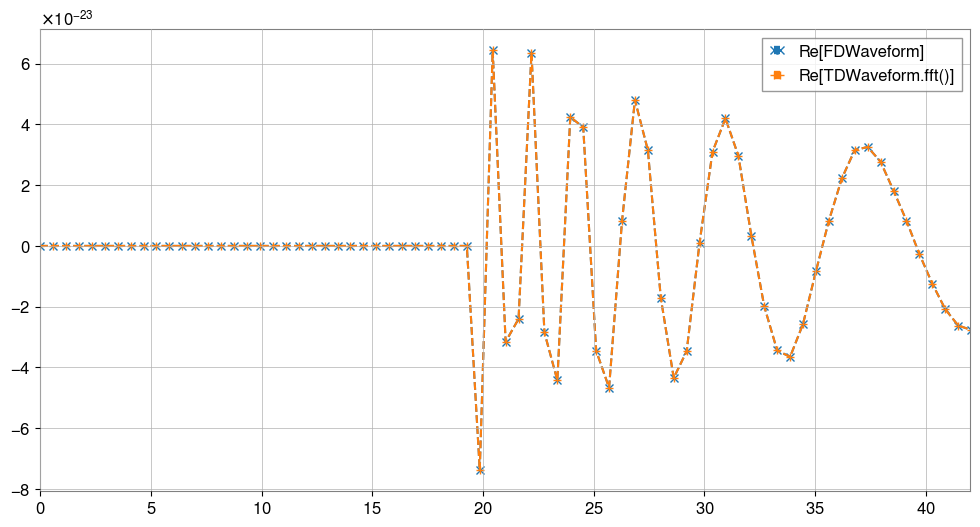

In [26]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(np.real(hp_f_coarse), 'x--', label='Re[FDWaveform]')

ax.plot(np.real(td_to_fd_waveform(fd_to_td_waveform(hp_f_coarse))), '+--', label='Re[TDWaveform.fft()]')

ax.legend()

ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()

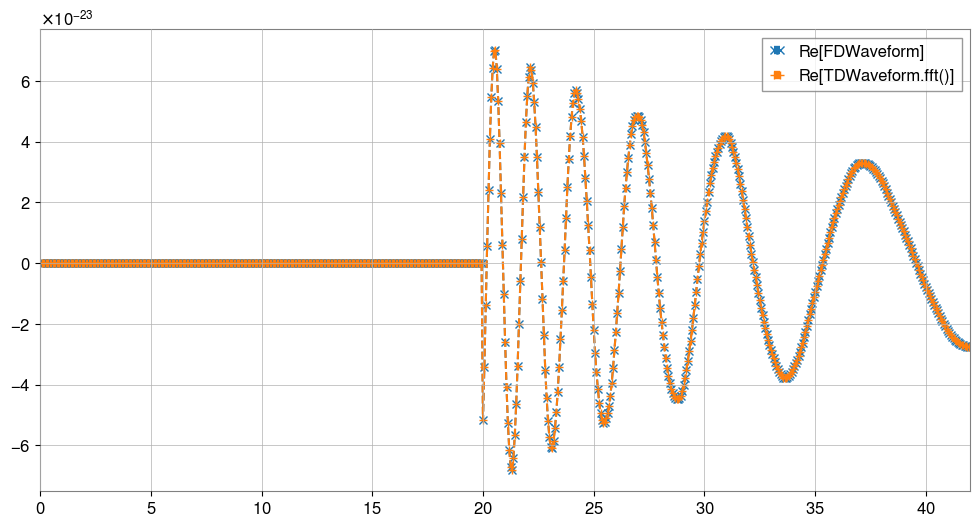

In [27]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(np.real(hp_f_fine), 'x--', label='Re[FDWaveform]')

ax.plot(np.real(td_to_fd_waveform(fd_to_td_waveform(hp_f_fine))), '+--', label='Re[TDWaveform.fft()]')

ax.legend()

ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()

In [28]:
f_min_comp, f_max_comp = 20.0 * u.Hz, 512.0 * u.Hz  # Restrict to interesting region, elsewhere only values close to zero and thus numerical errors might occur

print(np.all(np.isclose(np.real(hp_f_coarse.crop(start=f_min_comp, end=f_max_comp)), np.real(td_to_fd_waveform(fd_to_td_waveform(hp_f_coarse)).crop(start=f_min_comp, end=f_max_comp)), atol=0.0, rtol=0.001)))
print(np.all(np.isclose(np.real(hp_f_fine.crop(start=f_min_comp, end=f_max_comp)), np.real(td_to_fd_waveform(fd_to_td_waveform(hp_f_fine)).crop(start=f_min_comp, end=f_max_comp)), atol=0.0, rtol=0.001)))

True
True


Equal up to at least 0.1%

For a visual proof of that we plot the absolute differences

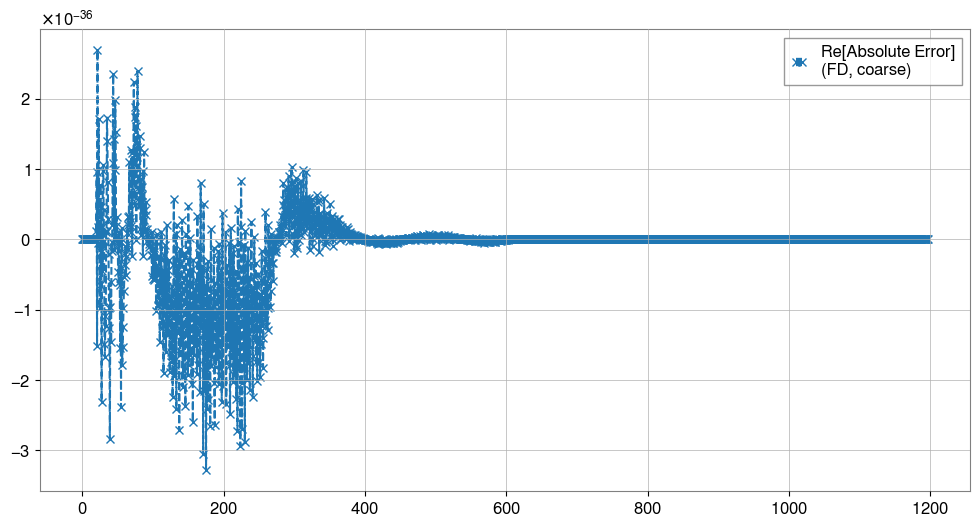

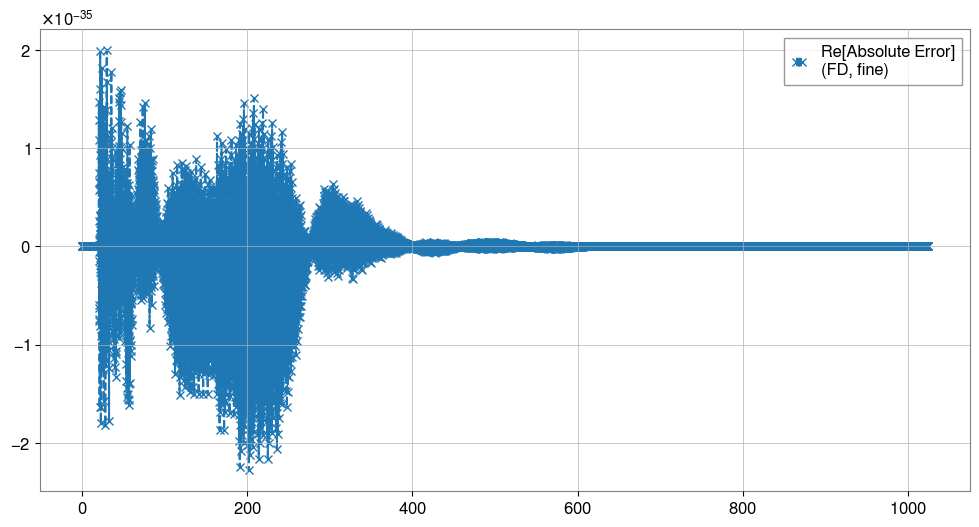

In [29]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(np.real(hp_f_coarse - td_to_fd_waveform(fd_to_td_waveform(hp_f_coarse))), 'x--', label='Re[Absolute Error]\n(FD, coarse)')

ax.legend()

# ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()



f,ax = plt.subplots(figsize=(12, 6))

ax.plot(np.real(hp_f_fine - td_to_fd_waveform(fd_to_td_waveform(hp_f_fine))), 'x--', label='Re[Absolute Error]\n(FD, fine)')

ax.legend()

# ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()

These are essentially random errors, especially for first plot one can see no systematic in error signal

### Time Domain

In [30]:
hp_t_fft_ifft = fd_to_td_waveform(td_to_fd_waveform(hp_t))

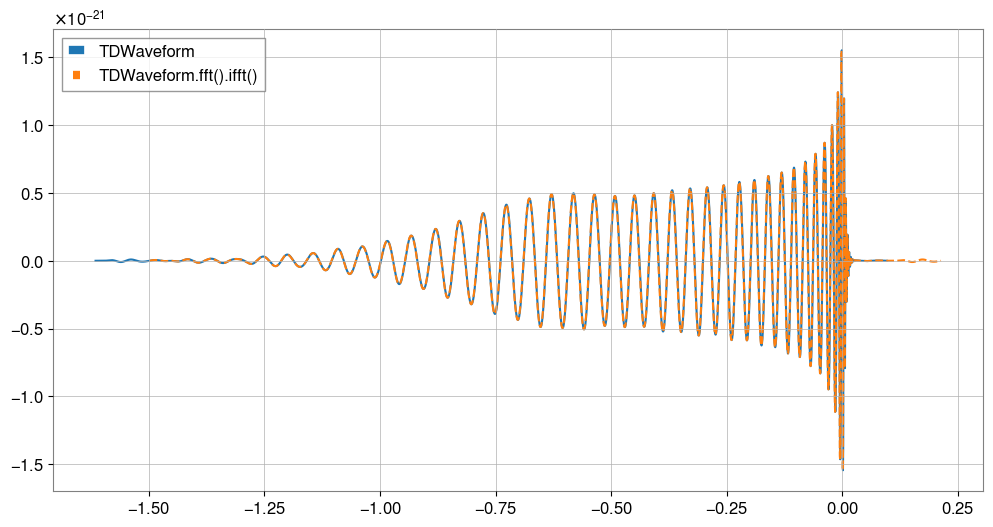

In [31]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_t_fft_ifft, '--', label='TDWaveform.fft().ifft()')

ax.legend()

# ax.set_xlim([-0.75, 0.1])
# ax.set_xlim([-0.1, 0.025])

plt.show()

Good agreement, apart from different end and start points everything is roughly equal. When zooming in, a slight phase shift can be observed, which makes sense given the rather raw sampling in frequency domain that this coarsely sampled signal represents (see signal in frequency domain).

This must not change for smaller df.

In [32]:
hp_t_fft_ifft_fine = fd_to_td_waveform(td_to_fd_waveform(pad_to_get_target_df(hp_t, df=0.0625 * u.Hz)))

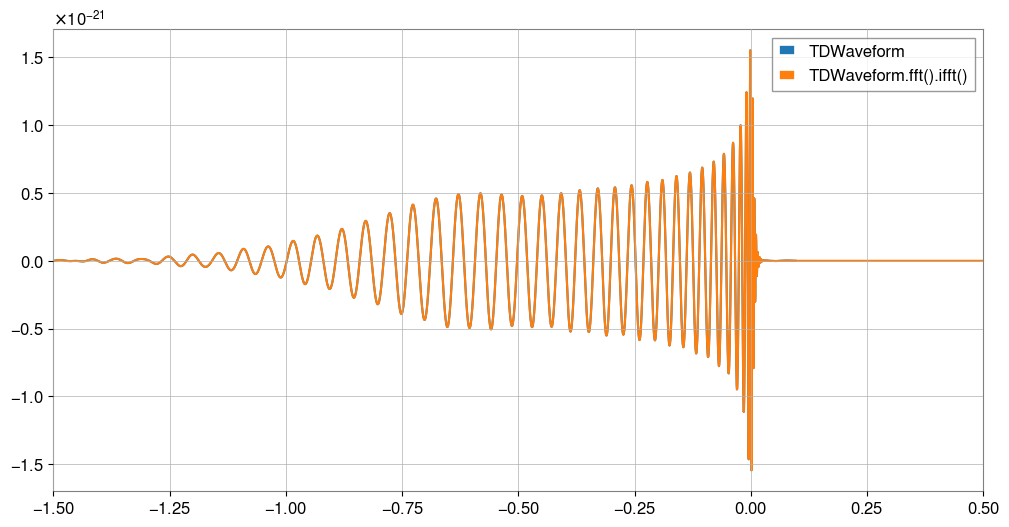

In [33]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_t_fft_ifft_fine, label='TDWaveform.fft().ifft()')

ax.legend()

ax.set_xlim([-1.5, 0.5])
# ax.set_xlim([-0.1, 0.025])

plt.show()

In [34]:
t_min_comp, t_max_comp = max(hp_t.t0, hp_t_fft_ifft_fine.t0), min(hp_t.times[-1], hp_t_fft_ifft_fine.times[-1])  # hp_t_fft_ifft_fine is padded to be much longer

print(np.all(np.isclose(hp_t.crop(start=t_min_comp, end=t_max_comp)[1:], hp_t_fft_ifft_fine.crop(start=t_min_comp, end=t_max_comp)[1:], atol=0.0, rtol=0.001)))
# Note: for some reason, first sample is not equal. Thus excluded here

True


Equal up to at least 0.1% for fine sampling. For coarse sampling, the following plot of absolute deviations shows a maximum amplitude error of roughly 10% prior to the signal. Of course, this is a substantial deviation, which shows the need for sufficiently fine sampling.

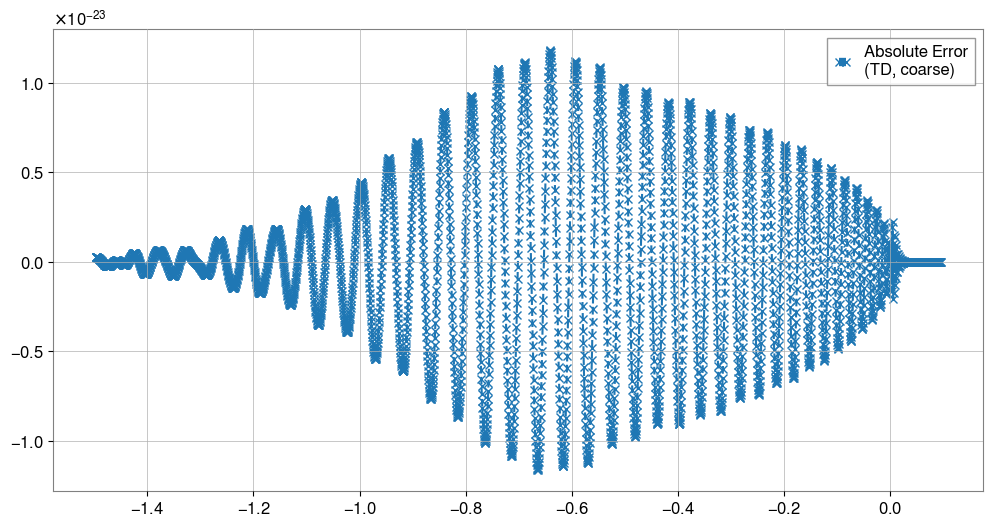

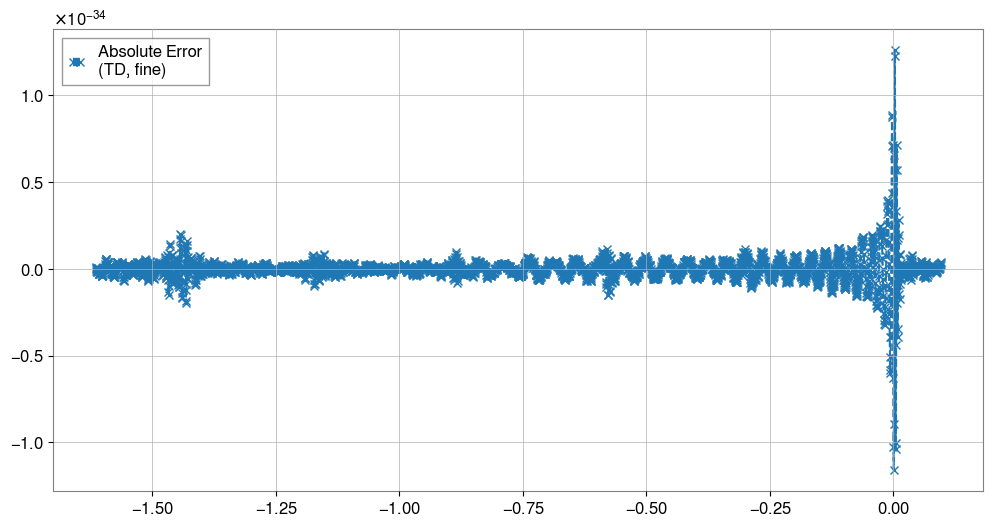

In [35]:
t_min_comp, t_max_comp = max(hp_t.t0, hp_t_fft_ifft.t0), min(hp_t.times[-1], hp_t_fft_ifft.times[-1])


f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t.crop(start=t_min_comp, end=t_max_comp)[2:] - hp_t_fft_ifft.crop(start=t_min_comp, end=t_max_comp), 'x--', label='Absolute Error\n(TD, coarse)')

ax.legend()

# ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()



t_min_comp, t_max_comp = max(hp_t.t0, hp_t_fft_ifft_fine.t0), min(hp_t.times[-1], hp_t_fft_ifft_fine.times[-1])

f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t.crop(start=t_min_comp, end=t_max_comp) - hp_t_fft_ifft_fine.crop(start=t_min_comp, end=t_max_comp), 'x--', label='Absolute Error\n(TD, fine)')

ax.legend()

# ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()

## Time Domain to Frequency Domain

- TODO for each: make zoom only in inset

Now we compare how well the FDWaveform generated by lal and our transformed TDWaveform agree

In [36]:
hp_t_f_coarse = td_to_fd_waveform(hp_t)

# For a finer resolution, we have to pad signal
hp_t_padded = pad_to_get_target_df(hp_t, df=hp_f_fine.df)
hp_t_f_fine = td_to_fd_waveform(hp_t_padded)

In [37]:
print(hp_f_coarse.df, hp_t_f_coarse.df)

print(hp_f_fine.df, hp_t_f_fine.df)

0.5839749073282008 Hz 0.5839749073282008 Hz
0.0625 Hz 0.0625 Hz


This demonstrates that `pad_to_get_target_df` does its job

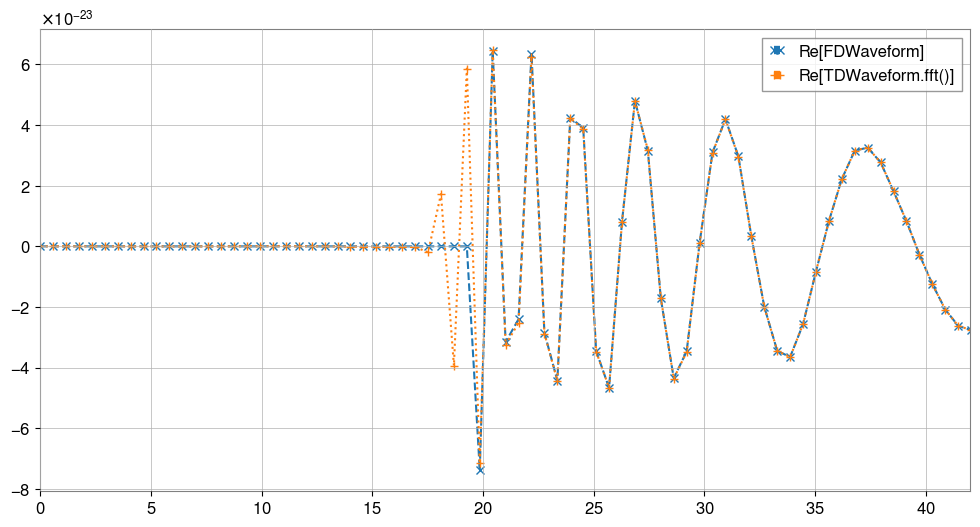

In [38]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(np.real(hp_f_coarse), 'x--', label='Re[FDWaveform]')

ax.plot(np.real(hp_t_f_coarse), '+:', label='Re[TDWaveform.fft()]')

ax.legend()

ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()

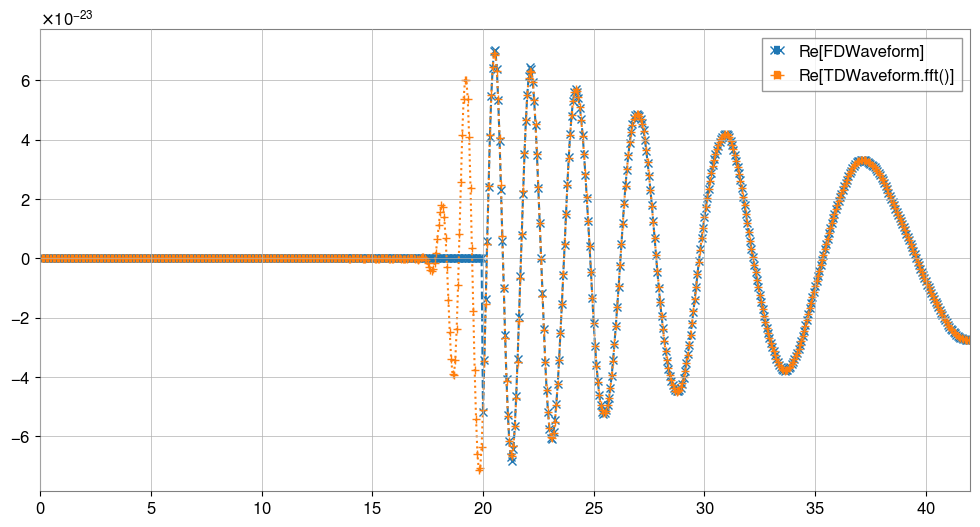

In [39]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(np.real(hp_f_fine), 'x--', label='Re[FDWaveform]')

ax.plot(np.real(hp_t_f_fine), '+:', label='Re[TDWaveform.fft()]')

ax.legend()

ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()

In [40]:
f_min_comp, f_max_comp = 25.0 * u.Hz, 512.0 * u.Hz  # Restrict to interesting region, elsewhere only values close to zero and thus numerical errors might occur

print(np.all(np.isclose(hp_f_coarse.crop(start=f_min_comp, end=f_max_comp), hp_t_f_coarse.crop(start=f_min_comp, end=f_max_comp), atol=0.0, rtol=0.01)))
print(np.all(np.isclose(hp_f_fine.crop(start=f_min_comp, end=f_max_comp), hp_t_f_fine.crop(start=f_min_comp, end=f_max_comp), atol=0.0, rtol=0.01)))

True
True


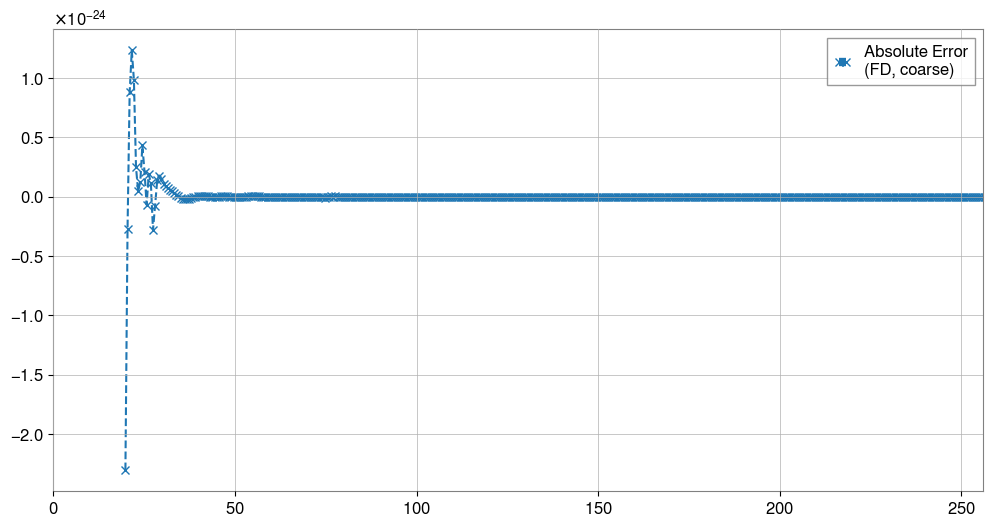

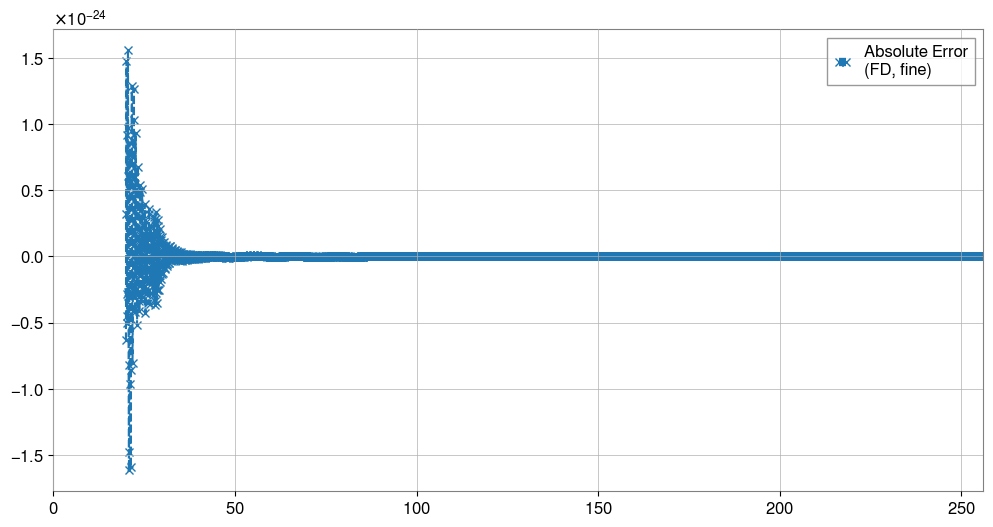

In [41]:
f_min_comp, f_max_comp = 20.0 * u.Hz, 512.0 * u.Hz  # Restrict to interesting region, elsewhere only values close to zero and thus numerical errors might occur


f,ax = plt.subplots(figsize=(12, 6))

ax.plot(np.real(hp_f_coarse.crop(start=f_min_comp, end=f_max_comp) - hp_t_f_coarse.crop(start=f_min_comp, end=f_max_comp)), 'x--', label='Absolute Error\n(FD, coarse)')

ax.legend()

# ax.set_xlim([0.0, 42])
ax.set_xlim([0.0, 256])

plt.show()



t_min_comp, t_max_comp = max(hp_t.t0, hp_t_fft_ifft_fine.t0), min(hp_t.times[-1], hp_t_fft_ifft_fine.times[-1])

f,ax = plt.subplots(figsize=(12, 6))

ax.plot(np.real(hp_f_fine.crop(start=f_min_comp, end=f_max_comp) - hp_t_f_fine.crop(start=f_min_comp, end=f_max_comp)), 'x--', label='Absolute Error\n(FD, fine)')

ax.legend()

# ax.set_xlim([0.0, 42])
ax.set_xlim([0.0, 256])

plt.show()

Very good agreement, except for beginning. Here, the FDWaveform perhaps has some tapering applied or the corresponding TDWaveform we use for own FFT has - in any case, there is a residual influence of this, causing slightly higher disagreement.

## Frequency Domain to Time Domain

Now we compare how well the TDWaveform generated by lal and our transformed FDWaveform agree

In [42]:
hp_f_t_coarse = fd_to_td_waveform(hp_f_coarse)
hp_f_t_fine = fd_to_td_waveform(hp_f_fine)

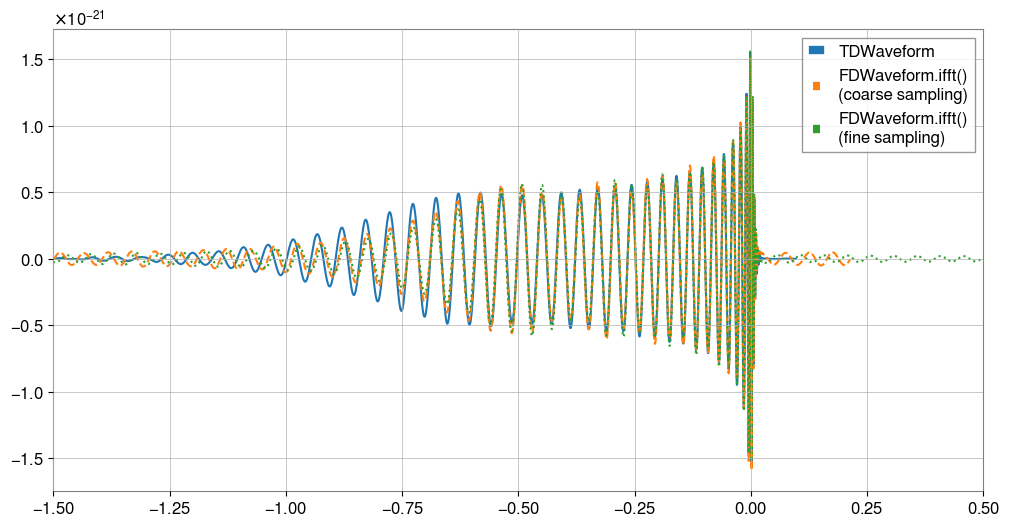

In [43]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_f_t_coarse, '--', label='FDWaveform.ifft()\n(coarse sampling)')

ax.plot(hp_f_t_fine, ':', label='FDWaveform.ifft()\n(fine sampling)')

ax.legend()

ax.set_xlim([-1.5, 0.5])

plt.show()

Close to merger, agreement has to be best

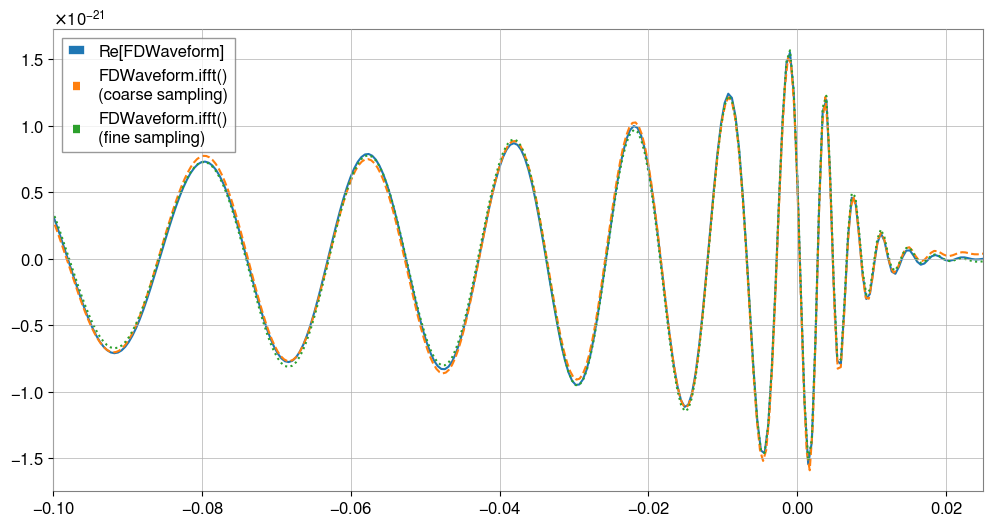

In [44]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t, label='Re[FDWaveform]')

ax.plot(hp_f_t_coarse, '--', label='FDWaveform.ifft()\n(coarse sampling)')

ax.plot(hp_f_t_fine, ':', label='FDWaveform.ifft()\n(fine sampling)')

ax.legend()

# ax.set_xlim([-0.5, 0.05])
ax.set_xlim([-0.1, 0.025])

plt.show()

Differences between coarse and fine sampling remain, which makes sense. For fine sampling, the results are reasonably equal.

Most of the differences from the plot before are perhaps caused by tapering that we do not apply, but is applied for lal waveform

## Impact of Tapering

To be examined

Hypothesis: causes slight differences of signals coming out of generator and signals in other domain that are converted using our procedures (tapering changes Fourier components slightly, also morphology in time domain)

## Impact of Filtering

### In Frequency Domain

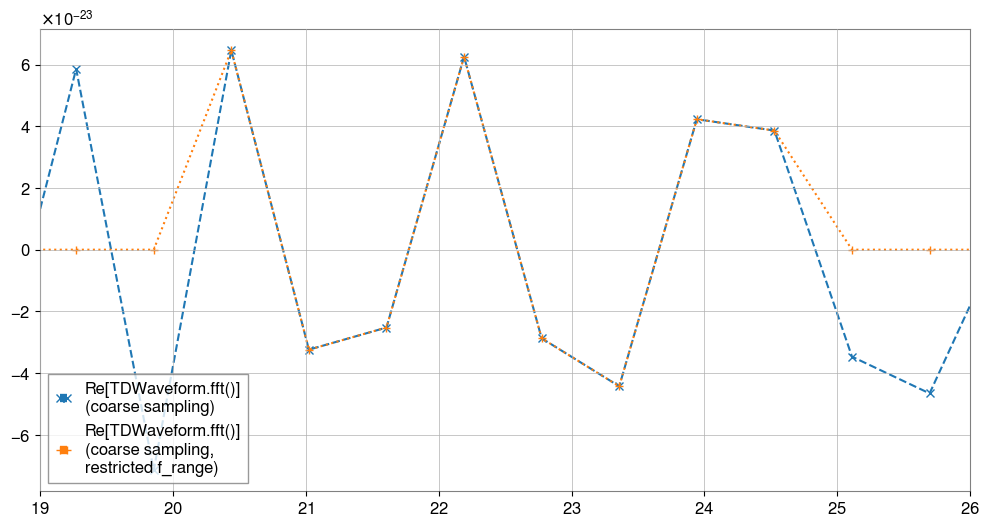

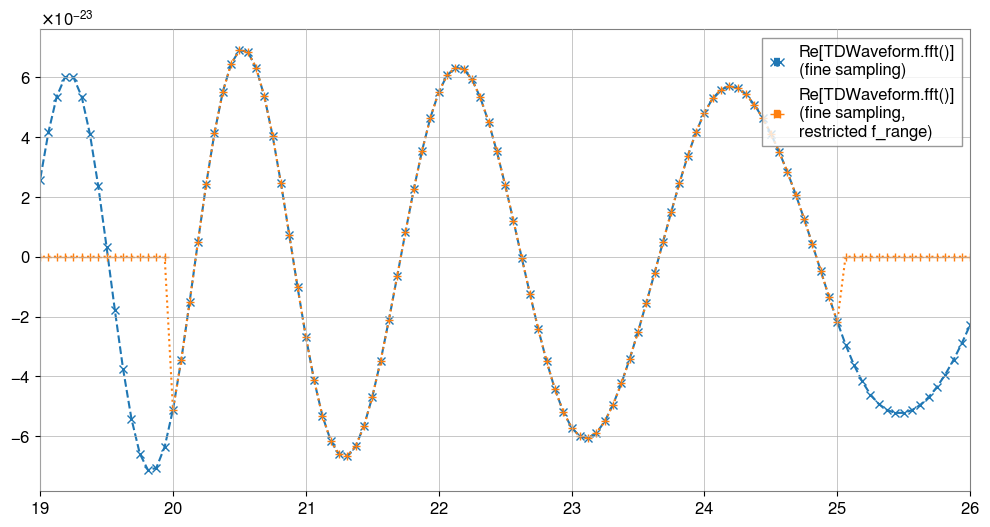

In [48]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(np.real(hp_t_f_coarse), 'x--', label='Re[TDWaveform.fft()]\n(coarse sampling)')

ax.plot(np.real(restrict_f_range(hp_t_f_coarse, f_range=[20, 25])), '+:', label='Re[TDWaveform.fft()]\n(coarse sampling,\nrestricted f_range)')

ax.legend()

# ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])
ax.set_xlim([19.0, 26])

plt.show()


f,ax = plt.subplots(figsize=(12, 6))

ax.plot(np.real(hp_t_f_fine), 'x--', label='Re[TDWaveform.fft()]\n(fine sampling)')

ax.plot(np.real(restrict_f_range(hp_t_f_fine, f_range=[20, 25])), '+:', label='Re[TDWaveform.fft()]\n(fine sampling,\nrestricted f_range)')

ax.legend()

# ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])
ax.set_xlim([19.0, 26.0])
# ax.set_xlim([19.9, 20.1])

plt.show()

Does exactly what it should do: setting frequency components out of range to zero while leaving other samples untouched

### In Time Domain

In [49]:
hp_t_coarse_filtered = fd_to_td_waveform(hp_t_f_coarse, f_range=[f_min, None])
hp_t_fine_filtered = fd_to_td_waveform(hp_t_f_fine, f_range=[f_min, None])

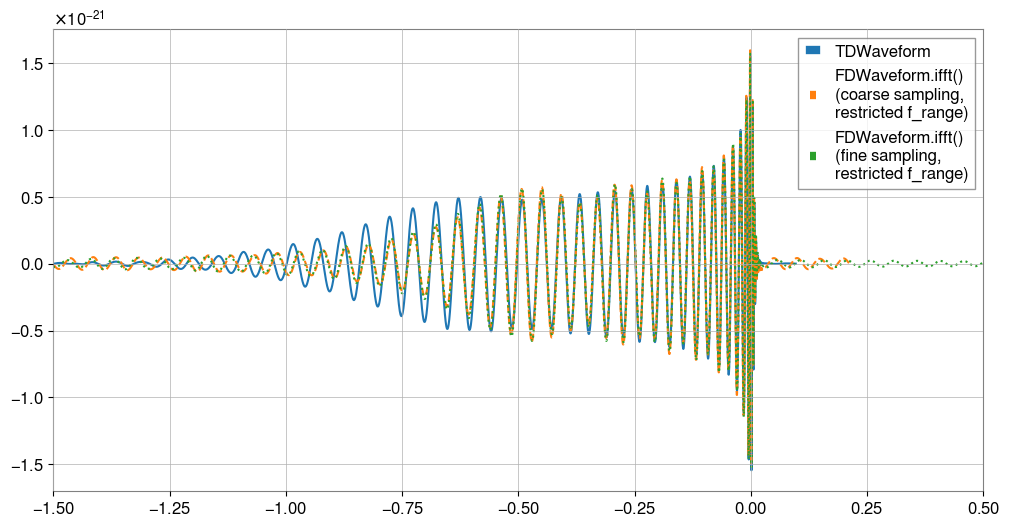

In [50]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_t_coarse_filtered, '--', label='FDWaveform.ifft()\n(coarse sampling,\nrestricted f_range)')

ax.plot(hp_t_fine_filtered, ':', label='FDWaveform.ifft()\n(fine sampling,\nrestricted f_range)')

ax.legend()

ax.set_xlim([-1.5, 0.5])

plt.show()

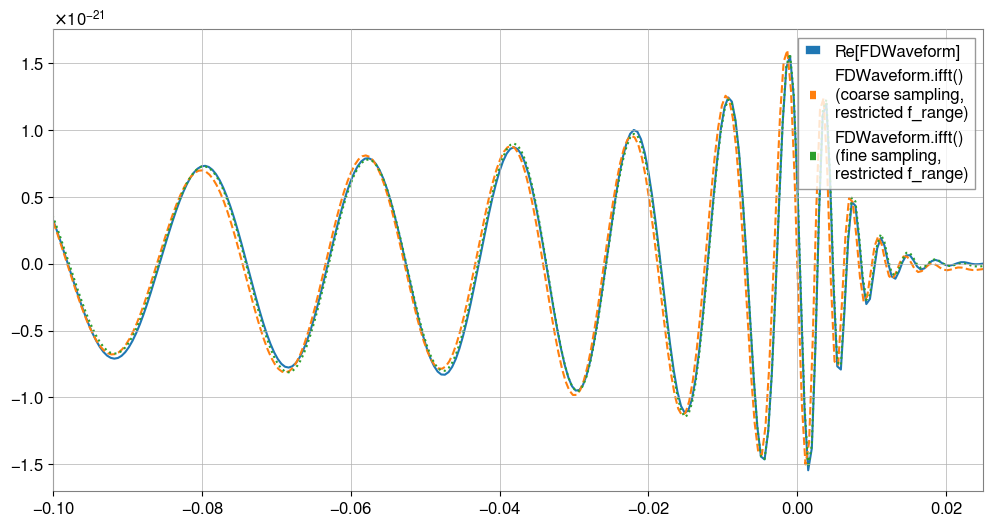

In [51]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t, label='Re[FDWaveform]')

ax.plot(hp_t_coarse_filtered, '--', label='FDWaveform.ifft()\n(coarse sampling,\nrestricted f_range)')

ax.plot(hp_t_fine_filtered, ':', label='FDWaveform.ifft()\n(fine sampling,\nrestricted f_range)')

ax.legend()

ax.set_xlim([-0.1, 0.025])

plt.show()

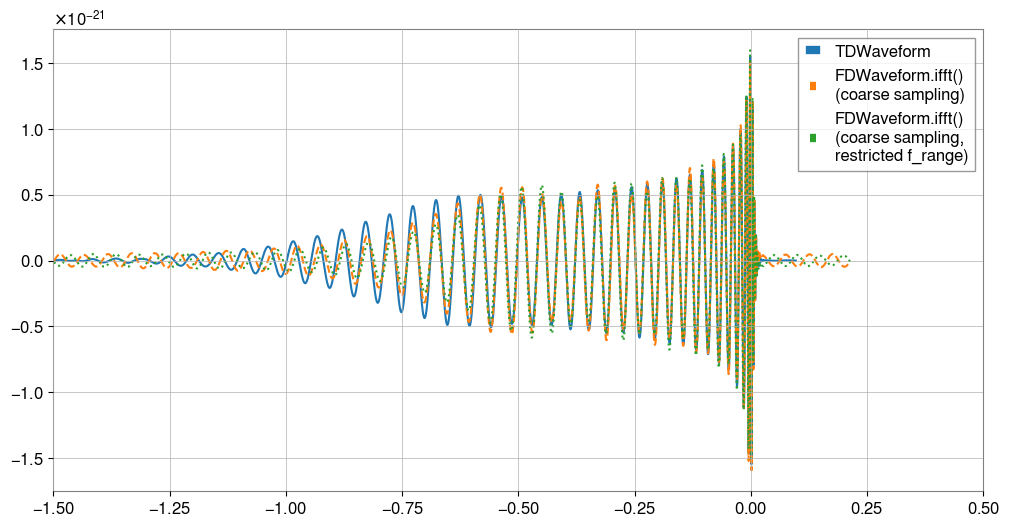

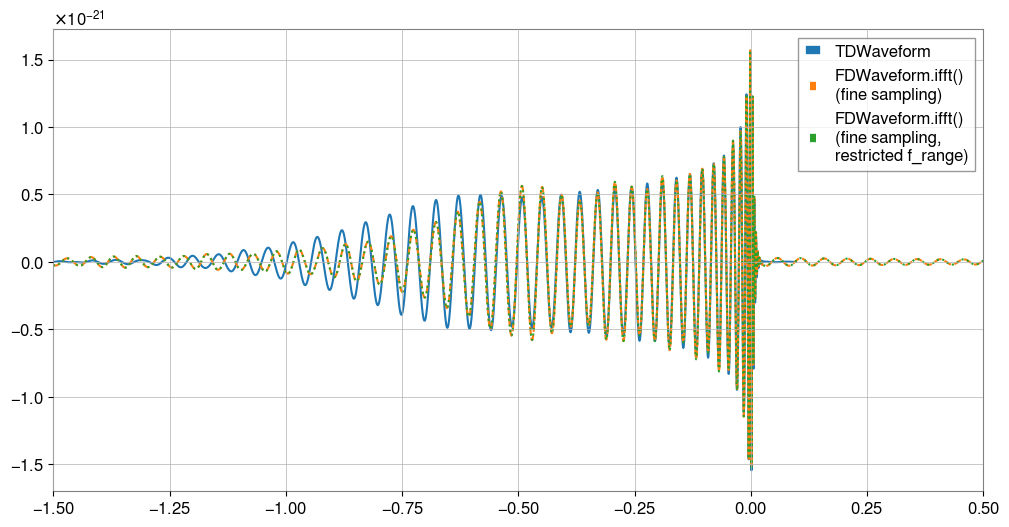

In [52]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_f_t_coarse, '--', label='FDWaveform.ifft()\n(coarse sampling)')

ax.plot(hp_t_coarse_filtered, ':', label='FDWaveform.ifft()\n(coarse sampling,\nrestricted f_range)')

ax.legend()

ax.set_xlim([-1.5, 0.5])

plt.show()



f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_f_t_fine, '--', label='FDWaveform.ifft()\n(fine sampling)')

ax.plot(hp_t_fine_filtered, ':', label='FDWaveform.ifft()\n(fine sampling,\nrestricted f_range)')

ax.legend()

ax.set_xlim([-1.5, 0.5])

plt.show()

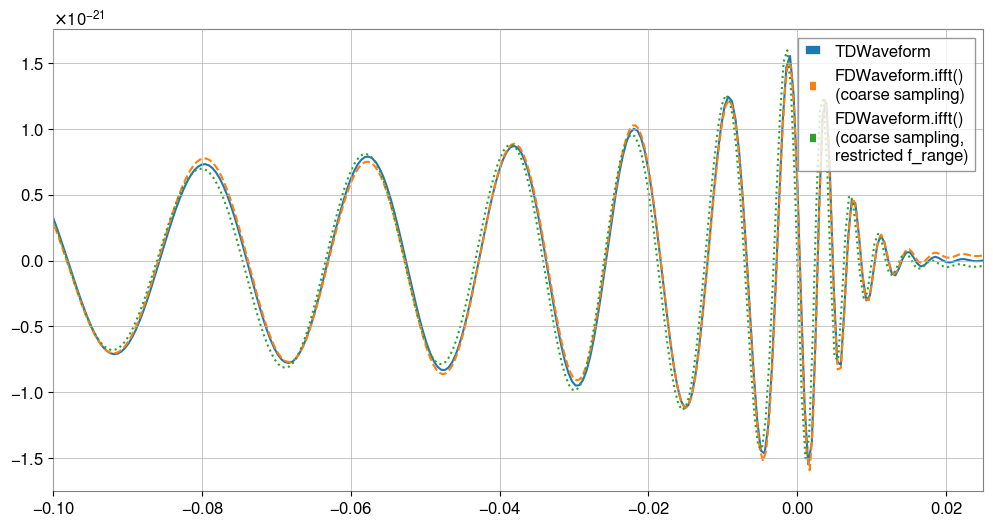

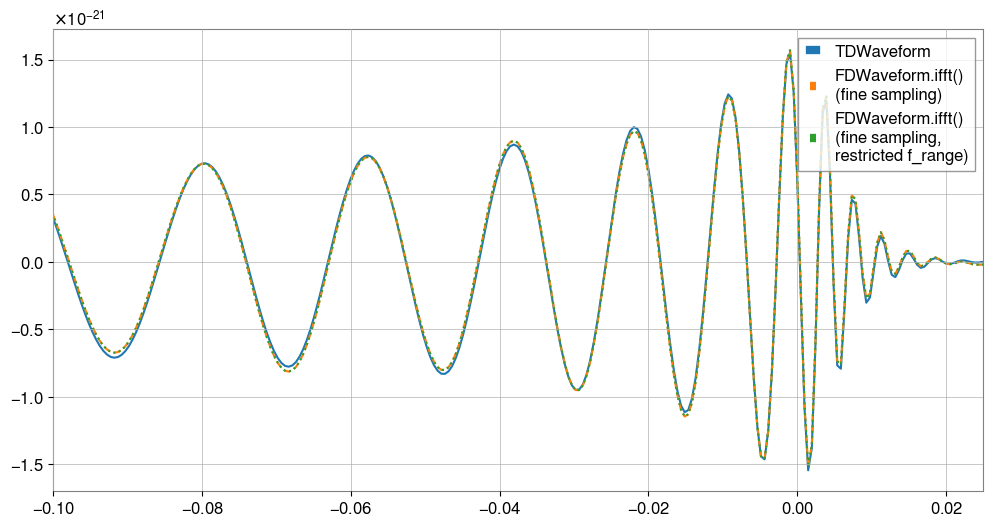

In [53]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_f_t_coarse, '--', label='FDWaveform.ifft()\n(coarse sampling)')

ax.plot(hp_t_coarse_filtered, ':', label='FDWaveform.ifft()\n(coarse sampling,\nrestricted f_range)')

ax.legend()

ax.set_xlim([-0.1, 0.025])

plt.show()



f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_f_t_fine, '--', label='FDWaveform.ifft()\n(fine sampling)')

ax.plot(hp_t_fine_filtered, ':', label='FDWaveform.ifft()\n(fine sampling,\nrestricted f_range)')

ax.legend()

ax.set_xlim([-0.1, 0.025])

plt.show()

Clearly, removing some Fourier components and thus information has an impact on the Fourier transform of the coarsely sampled signal. For fine sampling, this impact is negligible.

Generally speaking, filtering also increases the phase shift observed most prominently at the beginning of the signal.

## Impact of Padding

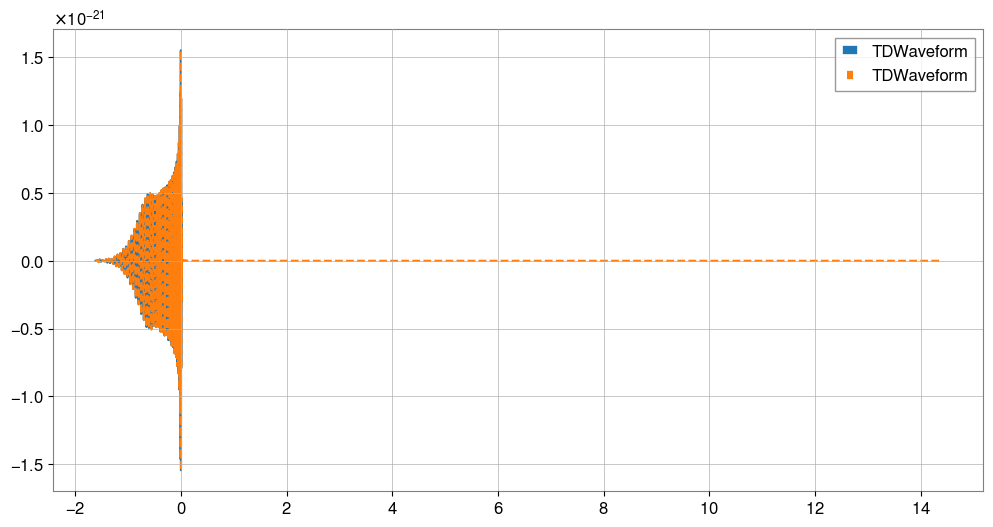

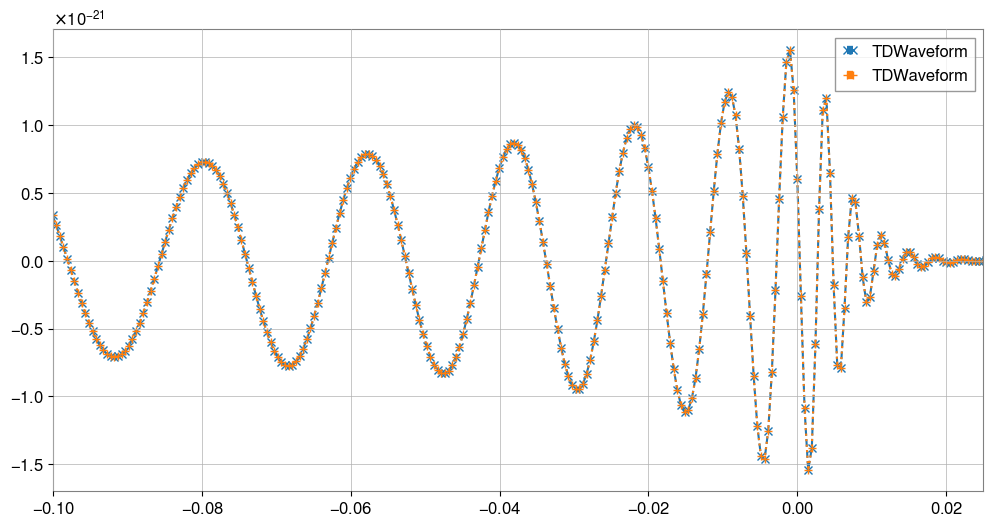

In [54]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t, label='TDWaveform')

ax.plot(pad_to_get_target_df(hp_t, df=0.0625 * u.Hz), '--', label='TDWaveform')

ax.legend()

plt.show()



f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t, 'x--', label='TDWaveform')

ax.plot(pad_to_get_target_df(hp_t, df=0.0625), '+:', label='TDWaveform')  # Input without unit works as well

ax.legend()

# ax.set_xlim([-1.5, 0.5])
ax.set_xlim([-0.1, 0.025])

plt.show()

Does exactly what it should do: increasing sample size by adding zeros after end of signal while leaving other samples untouched